In [4]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift, track_a_bend_parallel, track_a_drift_parallel


from csr2d.kick2 import csr2d_kick_calc, csr1d_steady_state_kick_calc

import time
import h5py

from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

## Beam definition 

In [2]:
# Glen's beam, which comes from Yunhai's 3D CSR paper!

gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34 # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Nb = 6.25e9
Q = e_charge * Nb


## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2



# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

#beam[5] = np.zeros(Np)    # turn off initial energy spread


# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

In [3]:
(24*50e-6*1.5**2)**(1/3)

0.1392476650083834

In [5]:
# Yunhai's beam for transient wakes

gamma = 5000
rho = 1.5 # Bend radius in m

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m

sigma_x = 50e-6
sigma_xp = emit_x / sigma_x
sigma_y = 0
sigma_yp = 0
sigma_z  = 50e-6
sigma_delta = 0

beam = np.zeros((6, Np))
beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2

## code

In [6]:
from csr2d.core2 import Es_case_B, Es_case_A, Fx_case_A

In [11]:
Es_case_B(0.002, 0.00, 0.999)

732.4141650895383

In [7]:
Fx_case_A(0.0001, 0.0001, 0.999, 0.000000001)

499175933281.12213

In [64]:
phi

0.06

In [6]:
# Copy of a section from kick2.py

from csr2d.convolution import fftconvolve2
from csr2d.kick2 import green_meshes_case_A, green_meshes_case_B
from scipy.signal import savgol_filter
from csr2d.central_difference import central_difference_z
from csr2d.deposit import split_particles, deposit_particles, histogram_cic_2d

# phi is the entrance angle of the bunch center
def csr2d_kick_calc_case_A(
    z_b, x_b, weight, *,
    gamma=None, rho=None, phi = None, x_observe = None,
    nz=100, nx=100,
    xlim=None, zlim=None, reuse_psi_grids=False, psi_s_grid_old=None, psi_x_grid_old=None,
    map_f=map, species="electron", imethod='map_coordinates', debug=False):
    
    # Grid setup
    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T

    # Differentiation in z
    ## lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)

    beta = np.sqrt(1 - 1 / gamma ** 2)

    t3 = time.time()

    if reuse_psi_grids == True:
        psi_s_grid = psi_s_grid_old
        psi_x_grid = psi_x_grid_old

    else:
        # Creating the potential grids        
        #psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  
        #Es_case_B_grid, zvec2, xvec2 = green_meshes_case_B(nz, nx, dz, dx, rho=rho, beta=beta) 
        Es_grid, Fx_grid, zvec2, xvec2 = green_meshes_case_A(nz, nx, dz, dx, rho=rho, beta=beta, alp=phi/2) 
    
    if debug:
        t4 = time.time()
        print("Computing potential grids take:", t4 - t3, "s")

    # Compute the wake via 2d convolution
    #conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
    #conv_s_case_B = fftconvolve2(lambda_grid_filtered, Es_case_B_grid)[0]  # [0] required is there is only one grid
    #conv_s_case_A, conv_x_case_A = fftconvolve2(lambda_grid_filtered, Es_case_A_grid, Fx_case_A_grid) 
    
    #if debug:
    #    t5 = time.time()
    #    print("Convolution takes:", t5 - t4, "s")

    #Ws_case_B_grid = (beta**2 / rho**2) * (conv_s_case_B) * (dz * dx)
    #Ws_case_A_grid = (1/gamma**2 / rho**2 ) * (conv_s_case_A) * (dz * dx)
    #Wx_case_A_grid = (1/gamma**2 / rho**2 ) * (conv_x_case_A) * (dz * dx)
    ##Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)
    
    
    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec2)  

    # Want "True" if (z > zi), where the grid values are set to ZERO
    condition_grid = np.array([(zvec2 < zi_vec[i]) for i in range(len(xvec2))])
    Es_grid_bounded = np.where(condition_grid.T, 0, Es_grid)
    Fx_grid_bounded = np.where(condition_grid.T, 0, Fx_grid)

    conv_s, conv_x = fftconvolve2(lambda_grid_filtered, Es_grid_bounded, Fx_grid_bounded)
  
    Ws_grid = (1/gamma**2 / rho**2) * (conv_s) * (dz*dx)
    Wx_grid = (1/gamma**2 / rho**2) * (conv_x) * (dz*dx)
    
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    
    return zvec,xvec,Ws_grid[:,x_observe_index]
    
    #return zvec,xvec,zvec2,xvec2, lambda_grid_filtered, Es_case_B_grid, Es_case_A_grid, Fx_case_A_grid, Ws_case_B_grid, Ws_case_A_grid, Wx_grid, dz, dx

In [7]:
# phi is the angle into the bend 
# x_observe should be a value in x_vec ( zero might not be one )..... TO BE FIXED

def compute_transient_wake_case_A(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered, Es_grid, Fx_grid, ploton=True):

    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec2)

    
    # Want "True" if (z > zi), where the grid values are set to ZERO
    condition_grid = np.array([(zvec2 > zi_vec[i]) for i in range(len(xvec2))])
    Es_grid_bounded = np.where(condition_grid.T, 0, Es_grid)
    Fx_grid_bounded = np.where(condition_grid.T, 0, Fx_grid)
    
    # This section is just for illustration, not required
    if ploton:
        zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")
        zm2_bounded = zm2
        zm2_bounded[condition_grid.T] = 0
        plt.imshow(zm2_bounded.T, origin='lower')
        plt.colorbar()
        plt.xlabel('zvec2 index', fontsize=16)
        plt.ylabel('xvec2 index', fontsize=16)
        plt.title('z value with boundaries of $\psi_s$\n (x ='+ str(x_observe*1000)+'mm, $\phi=$'+str(phi)+')',  fontsize=20)
        #plt.clf()
    
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered, Es_grid_bounded, Fx_grid_bounded )
  
    Ws_grid = (1/gamma**2 / rho**2 ) * (conv_s) * (dz * dx)
    Wx_grid = (1/gamma**2 / rho**2 ) * (conv_x) * (dz * dx)
    
    
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    print('x_observe_index :', x_observe_index)
    
    #plt.scatter(zvec, Ws_grid[:,x_observe_index])
    
    #return Ws_grid[:,x_observe_index], condition_grid, psi_s_grid_bounded
    return Ws_grid[:,x_observe_index]
    #return Ws_grid

In [8]:
zvec,xvec,zvec2,xvec2, lambda_grid_filtered, Es_case_B_grid, Es_case_A_grid, Fx_case_A_grid, Ws_case_B_grid, Ws_case_A_grid, Wx_case_A_grid, dz, dx = csr2d_kick_calc_new(beam[4,:], beam[0,:], 
                                           charges, gamma=gamma, rho=rho, phi=0.01, 
                                           nz=400, nx=300, map_f = map, debug=True)

NameError: name 'csr2d_kick_calc_new' is not defined

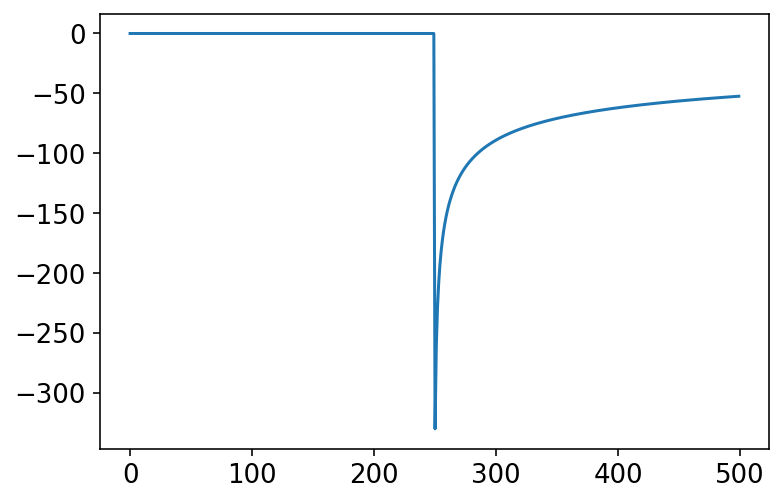

In [24]:
plt.plot(psi_s_grid[:,199])

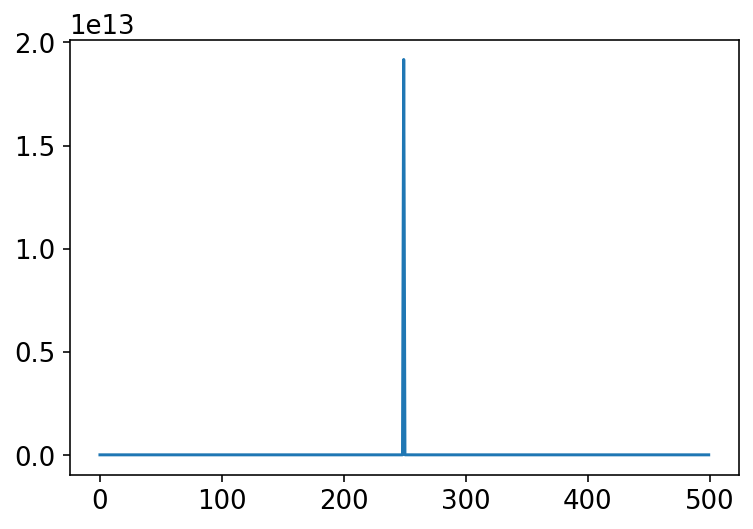

In [23]:
plt.plot(Es_grid[:,199])

In [21]:
from csr2d.core import alpha

In [106]:
rel = (psi_s_grid_prime[:,198]*rho - Es_grid[:,198]) / (psi_s_grid_prime[:,198]*rho)
rel[240:260]

array([0.01234568, 0.01562501, 0.02040817, 0.02777779, 0.04000001,
       0.0625    , 0.11111111, 0.24999995, 0.99921735, 1.        ,
       0.9369693 , 0.13755256, 0.05909562, 0.03286724, 0.02091939,
       0.01447756, 0.01060898, 0.00810394, 0.0063888 , 0.00516284])

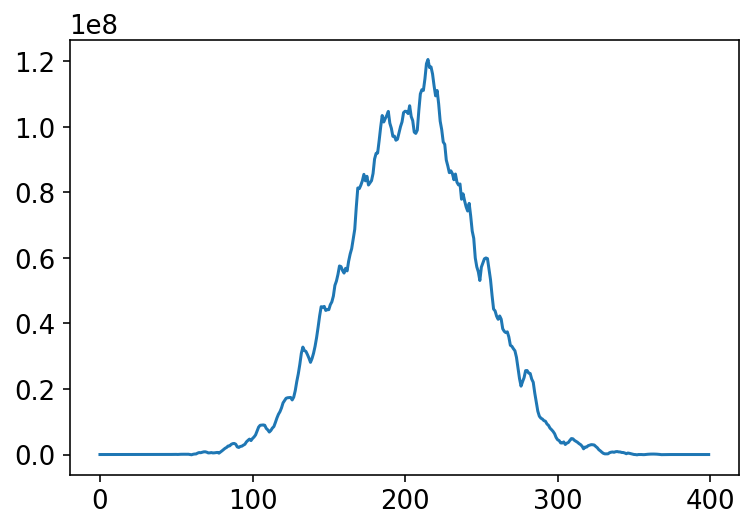

In [16]:
plt.plot(lambda_grid_filtered[:,200])

In [40]:
Z.shape

(600, 800)

In [39]:
psi_s_grid.shape

(800, 600)

Text(0.5, 0.92, 'psi_s at the first step of chicane')

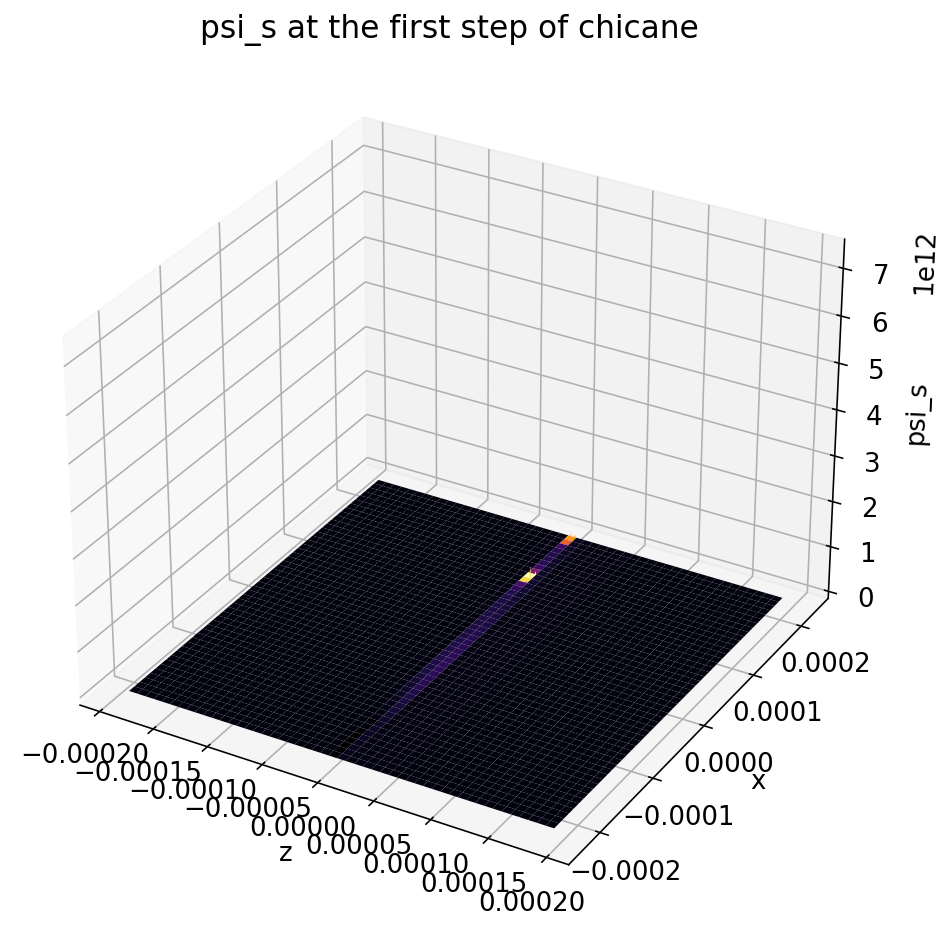

In [43]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec2, xvec2, indexing='ij')

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
ax.plot_surface(Z,X, Es_case_B_grid , cmap='inferno')
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

Text(0.5, 0.92, '$\\lambda(z,x)$ at the first step of chicane')

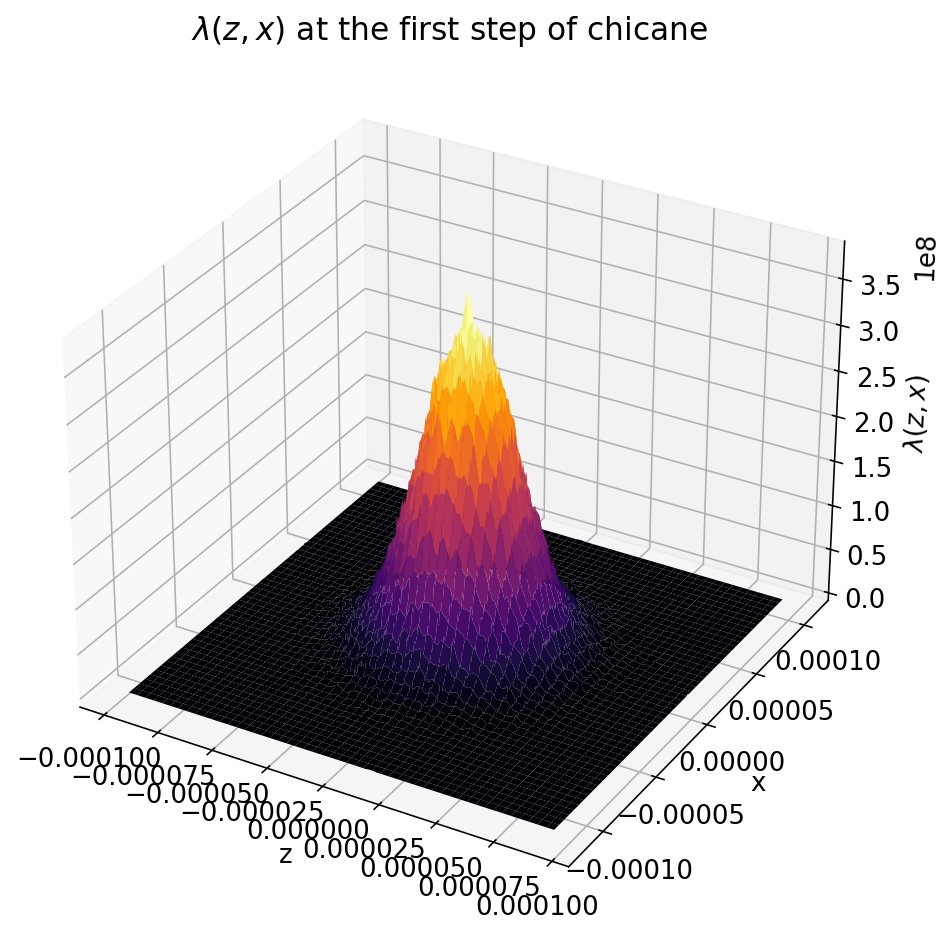

In [51]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
ax.plot_surface(Z,X, lambda_grid_filtered , cmap='inferno')
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('$\lambda(z,x)$')
ax.set_title('$\lambda(z,x)$ at the first step of chicane')

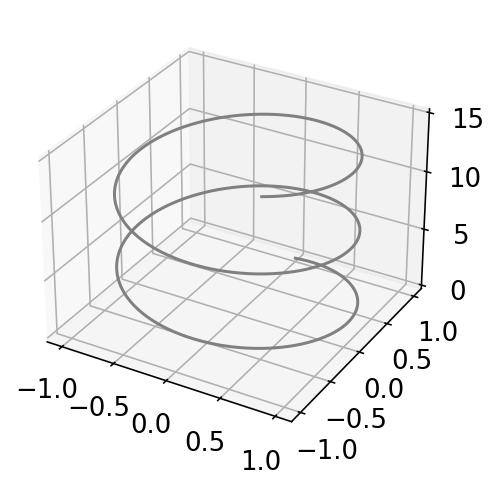

In [3]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

Text(0.5, 0.92, 'psi_s at the first step of chicane')

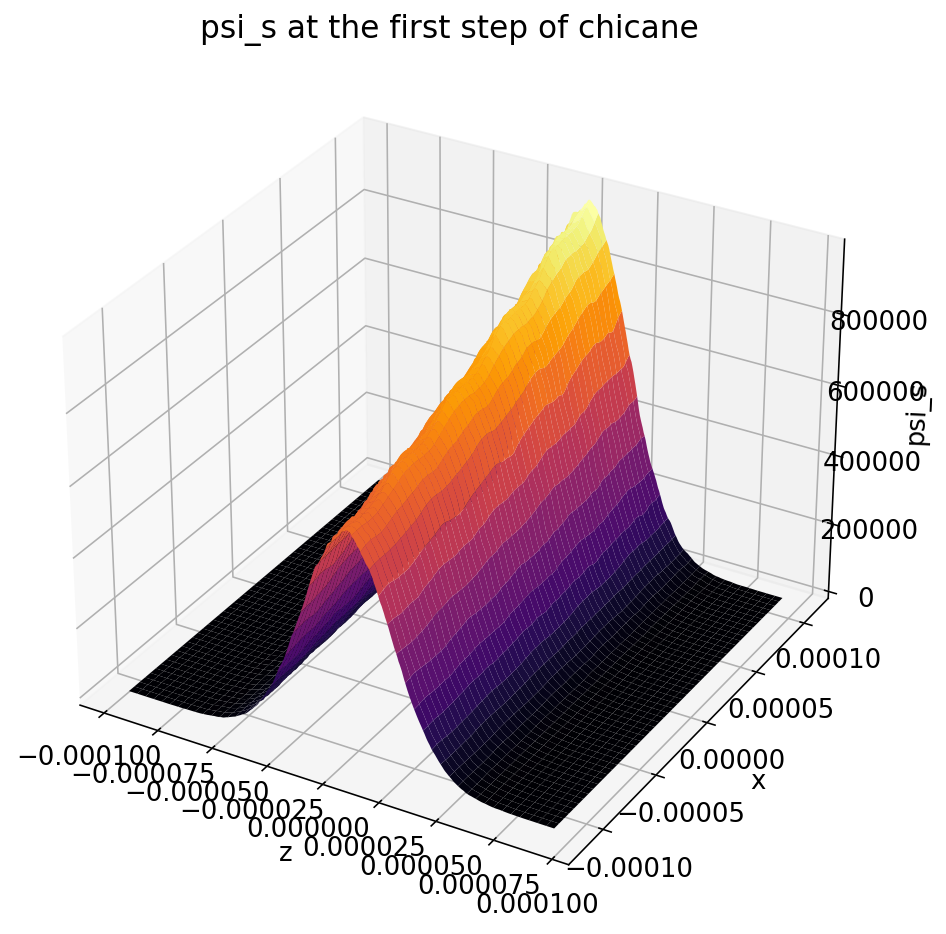

In [66]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
ax.plot_surface(Z,X, Ws_case_A_grid , cmap='inferno')
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

Text(0.5, 1.0, 'CSR wake along \n x= -0.00 m')

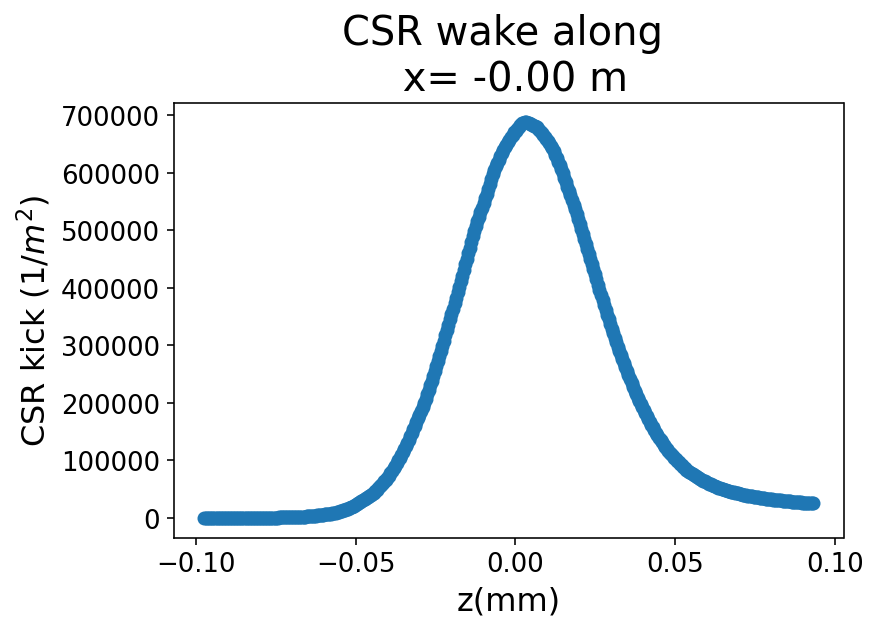

In [67]:
# This should look like steady-state wake
xix = np.argmin(np.abs(xvec - 0))
plt.scatter(zvec*10**3, Ws_case_B_grid[:,xix])


plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(f'CSR wake along \n x= {xvec[xix]:.2f} m',  fontsize=20)

Text(0, 0.5, '$W_s\\, (1/\\mathrm{m^2})$')

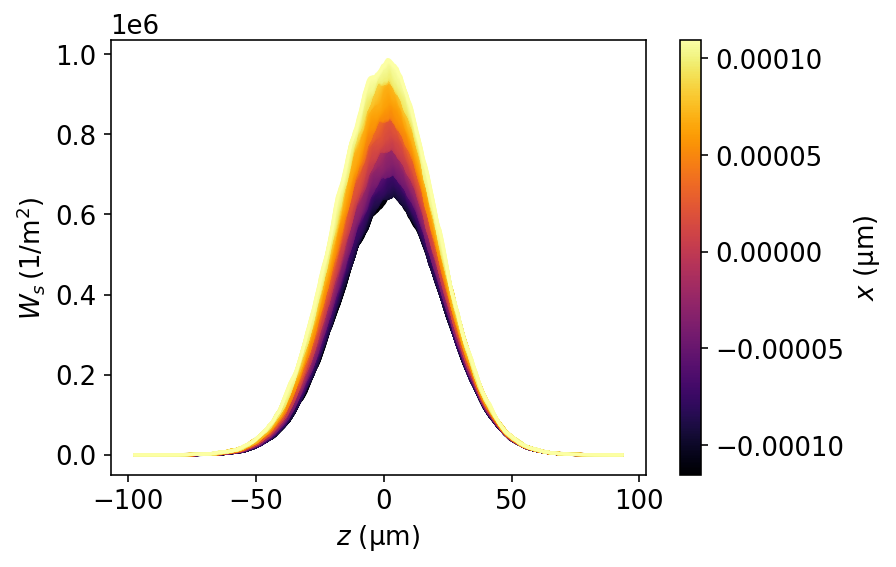

In [68]:
W=Ws_case_A_grid.T   # *kick_factor*p0c/W0

cmap = matplotlib.cm.get_cmap('inferno')
colors = cmap(np.linspace(0,1,len(W)))
fig, ax = plt.subplots(figsize=(6,4))
for i, ws in enumerate(W):
    ax.plot(zvec*1e6, ws, color=colors[i])
    
xmin = min(xvec) 
xmax = max(xvec)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=xmin, vmax=xmax))
cbar = fig.colorbar(sm)  

cbar.set_label('$x$'+' (µm)')
#ax.set_title('2D CSR wake')
ax.set_xlabel('$z$'+' (µm)')
ax.set_ylabel(r'$W_s\, (1/\mathrm{m^2})$')
#plt.savefig('Ws.png', dpi=150)

Text(0, 0.5, '$W_s\\, (1/\\mathrm{m^2})$')

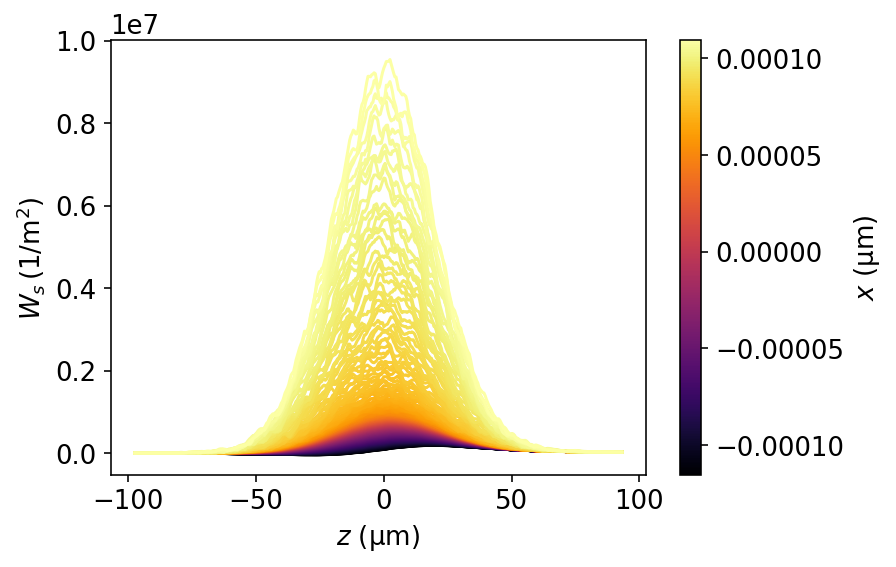

In [17]:
W=Ws_case_B_grid.T   # *kick_factor*p0c/W0

cmap = matplotlib.cm.get_cmap('inferno')
colors = cmap(np.linspace(0,1,len(W)))
fig, ax = plt.subplots(figsize=(6,4))
for i, ws in enumerate(W):
    ax.plot(zvec*1e6, ws, color=colors[i])
    
xmin = min(xvec) 
xmax = max(xvec)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=xmin, vmax=xmax))
cbar = fig.colorbar(sm)  

cbar.set_label('$x$'+' (µm)')
#ax.set_title('2D CSR wake')
ax.set_xlabel('$z$'+' (µm)')
ax.set_ylabel(r'$W_s\, (1/\mathrm{m^2})$')
#plt.savefig('Ws.png', dpi=150)

In [10]:
# Copy of a section from kick2.py

from csr2d.convolution import fftconvolve2
from csr2d.kick2 import green_meshes
from scipy.signal import savgol_filter
from csr2d.central_difference import central_difference_z
from csr2d.deposit import split_particles, deposit_particles, histogram_cic_2d

def csr2d_kick_calc_copy(
    z_b,x_b,weight,*,
    gamma=None,rho=None,nz=100,nx=100,xlim=None,zlim=None,
    reuse_psi_grids=False,psi_s_grid_old=None,psi_x_grid_old=None,map_f=map,
    species="electron",imethod='map_coordinates',debug=False):
    
    # Grid setup
    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T

    # Differentiation in z
    lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)

    beta = np.sqrt(1 - 1 / gamma ** 2)

    t3 = time.time()

    if reuse_psi_grids == True:
        psi_s_grid = psi_s_grid_old
        psi_x_grid = psi_x_grid_old

    else:
        # Creating the potential grids        
        psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  
    
    if debug:
        t4 = time.time()
        print("Computing potential grids take:", t4 - t3, "s")

    # Compute the wake via 2d convolution
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
    
    if debug:
        t5 = time.time()
        print("Convolution takes:", t5 - t4, "s")

    Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)
    Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)
    
    return zvec,xvec,zvec2,xvec2, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, Ws_grid, Wx_grid, dz, dx

In [11]:
zvec,xvec,zvec2,xvec2, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, Ws_grid, Wx_grid, dz, dx = csr2d_kick_calc_copy(beam[4,:], beam[0,:], 
                                           charges, gamma=gamma, rho=rho, 
                                           nz=400, nx=300,
                                           map_f = map, debug=True)

Depositing particles takes: 0.7830185890197754 s
Computing potential grids take: 0.036589860916137695 s
Convolution takes: 0.06258463859558105 s


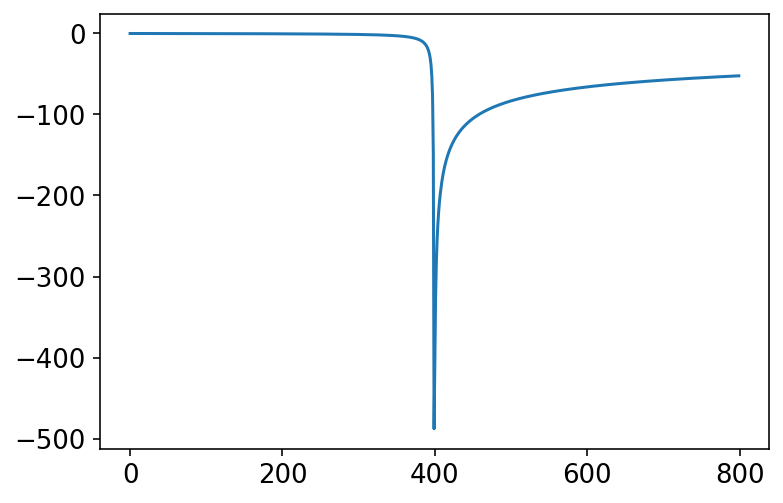

In [105]:
plt.plot(psi_s_grid[:,199])

In [91]:
# Directly numerically differentiate the psi_s_grid
psi_s_grid_prime = central_difference_z(psi_s_grid, 800, 600, dz, order=1)

In [92]:
xvec[xix]

-0.00010766298405672258

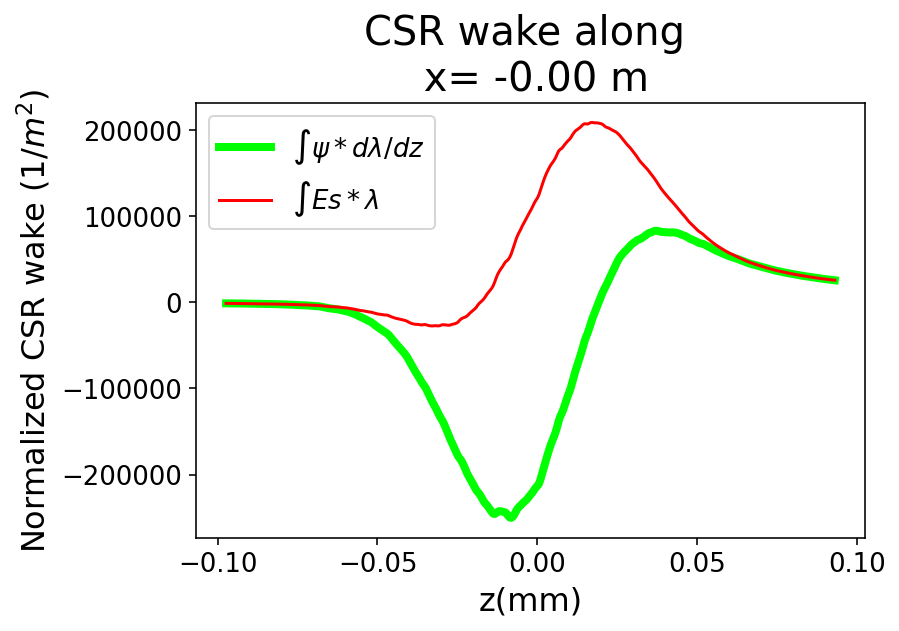

In [95]:
#Ws_grid[:,xix]

xix=10
plt.plot(zvec*1e3, Ws_grid[:,xix], label='$\int \psi * d\lambda/dz$',c='lime',linewidth=4.0)

plt.plot(zvec*1e3, Ws_case_B_grid[:,xix], label='$\int Es *\lambda$',c='red')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Normalized CSR wake $(1/m^2)$', fontsize=16)
plt.title(f'CSR wake along \n x= {xvec[xix]:.2f} m',  fontsize=20)
plt.legend()

In [97]:
xix = np.argmin(np.abs(xvec - 0))
xix

153

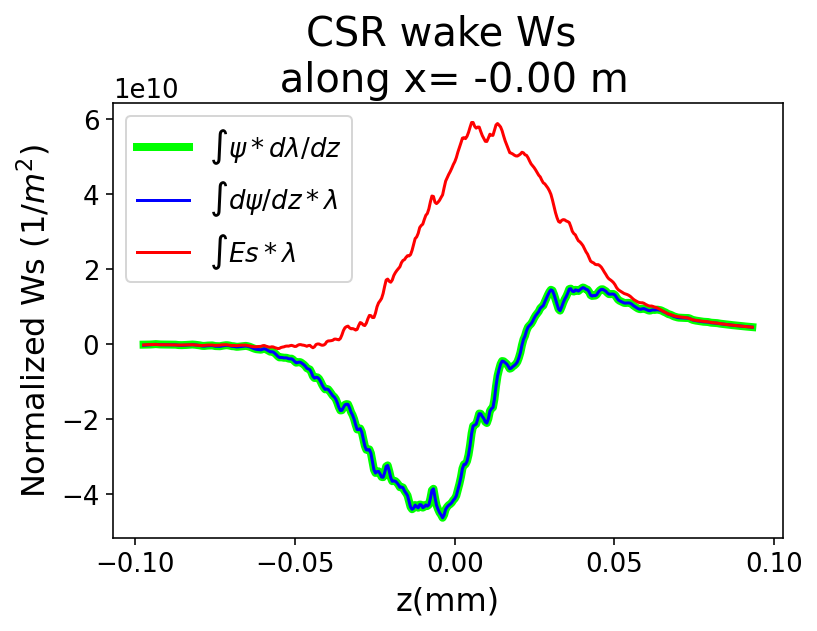

In [140]:
# Just for testing, do 1D convolution along x=0 
from scipy.signal import convolve as ssconv

haha = np.convolve(lambda_grid_filtered_prime[:,xix], psi_s_grid[:,199],mode='valid')*dz;
haha = haha[0:-1]  # trim to match zvec size
plt.plot(zvec*1e3,haha, label='$\int \psi * d\lambda/dz$',c='lime',linewidth=4.0)

kaka = np.convolve(lambda_grid_filtered[:,xix], psi_s_grid_prime[:,199],mode='valid')*dz;
kaka = kaka[0:-1]  # trim to match zvec size
plt.plot(zvec*1e3, kaka, label='$\int d\psi/dz *\lambda$',c='blue')

jaja = np.convolve(lambda_grid_filtered[:,xix], Es_case_B_grid[:,199]/rho,mode='valid')*dz;
jaja = jaja[0:-1]  # trim to match zvec size
plt.plot(zvec*1e3, jaja, label='$\int Es *\lambda$',c='red')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Normalized Ws $(1/m^2)$', fontsize=16)
plt.title(f'CSR wake Ws \n along x= {xvec[xix]:.2f} m',  fontsize=20)
plt.legend()

# Compare Es_grid with psi_s_grid_derivative directly...

In [126]:
xix2 = np.argmin(np.abs(xvec2 - 0))
xix2

299

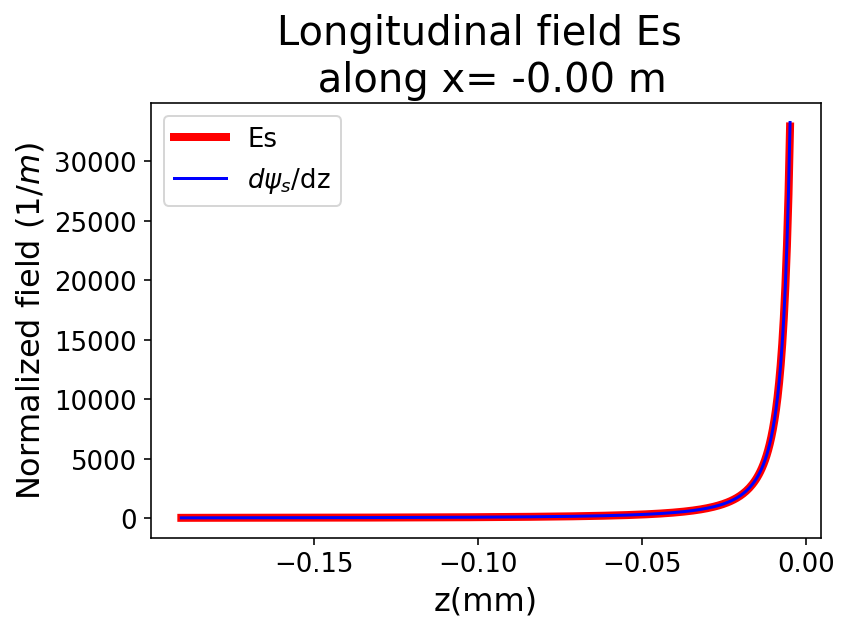

In [135]:
ix_low = 0
ix_high = 390
plt.plot(zvec2[ix_low:ix_high]*1e3,Es_case_B_grid[ix_low:ix_high,xix2+1]/rho, c='red',linewidth=4.0, label='Es')
plt.plot(zvec2[ix_low:ix_high]*1e3,psi_s_grid_prime[ix_low:ix_high,xix2+1], c='blue',  label='$d\psi_s$/dz')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Normalized field $(1/m)$', fontsize=16)
plt.title(f'Longitudinal field Es \n along x= {xvec[xix]:.2f} m',  fontsize=20)
plt.legend()

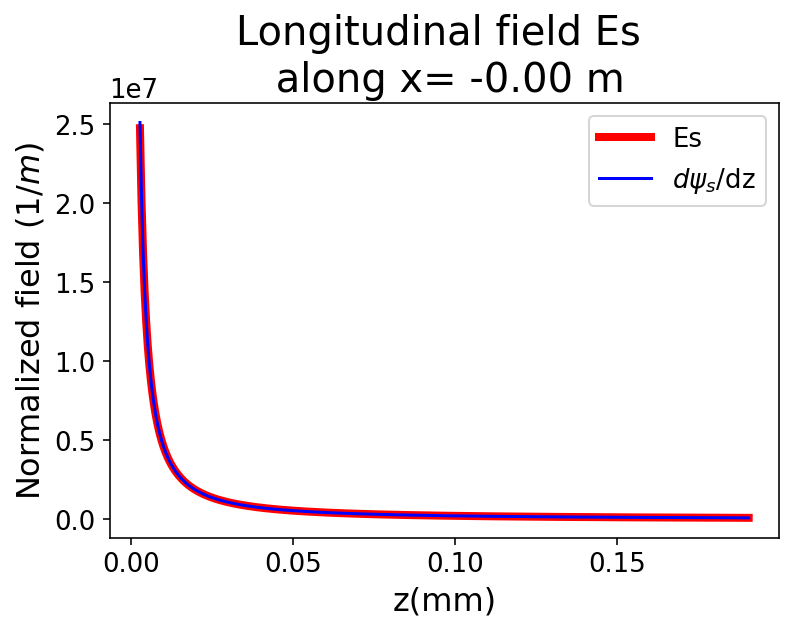

In [136]:
ix_low = 405
ix_high = 799
plt.plot(zvec2[ix_low:ix_high]*1e3,Es_case_B_grid[ix_low:ix_high,xix2]/rho, c='red',linewidth=4.0, label='Es')
plt.plot(zvec2[ix_low:ix_high]*1e3,psi_s_grid_prime[ix_low:ix_high,xix2], c='blue',  label='$d\psi_s$/dz')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Normalized field $(1/m)$', fontsize=16)
plt.title(f'Longitudinal field Es \n along x= {xvec[xix]:.2f} m',  fontsize=20)
plt.legend()

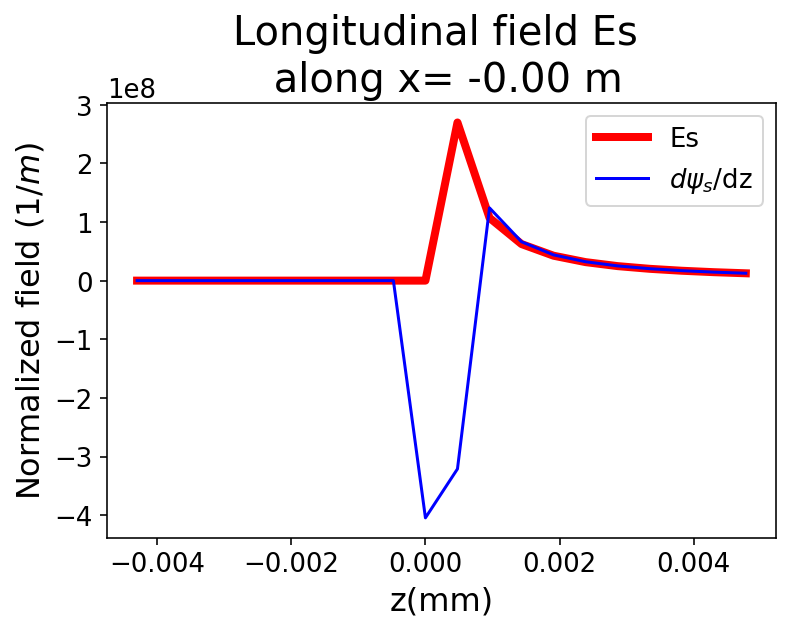

In [137]:
ix_low = 390
ix_high = 410
plt.plot(zvec2[ix_low:ix_high]*1e3,Es_case_B_grid[ix_low:ix_high,xix2]/rho, c='red',linewidth=4.0, label='Es')
plt.plot(zvec2[ix_low:ix_high]*1e3,psi_s_grid_prime[ix_low:ix_high,xix2], c='blue', label='$d\psi_s$/dz')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Normalized field $(1/m)$', fontsize=16)
plt.title(f'Longitudinal field Es \n along x= {xvec[xix]:.2f} m',  fontsize=20)
plt.legend()

In [121]:
psi_s_grid_prime[245:251,199]

array([ 1.18864067e-02,  1.20006991e-02,  1.24088861e-02,  1.22456113e-02,
       -2.15730707e+08, -1.71225379e+08])

In [120]:
Es_grid[245:251,199]

array([ 8.42478664e-02,  5.45989549e-02, -2.37801305e-02, -2.17817076e-01,
        1.91709658e+13,  1.48711310e+09])

Text(0.5, 1.0, 'CSR wake along x= 0.00 m\n')

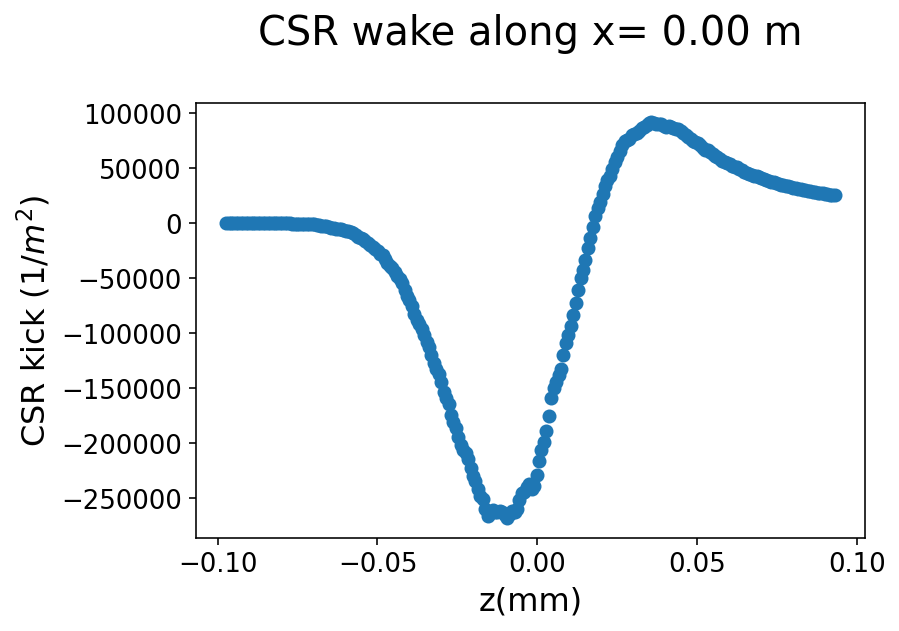

In [47]:
# This should look like steady-state wake
xix = np.argmin(np.abs(xvec - 0))
plt.scatter(zvec*10**3, Ws_grid[:,xix])

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title(f'CSR wake along x= {xvec[xix]:.2f} m\n',  fontsize=20)

In [63]:
psi_s_grid_prime.shape

(500, 400)

In [65]:
Es_grid.shape

(500, 400)

In [ ]:
psi_s_grid_prime-Es_grid

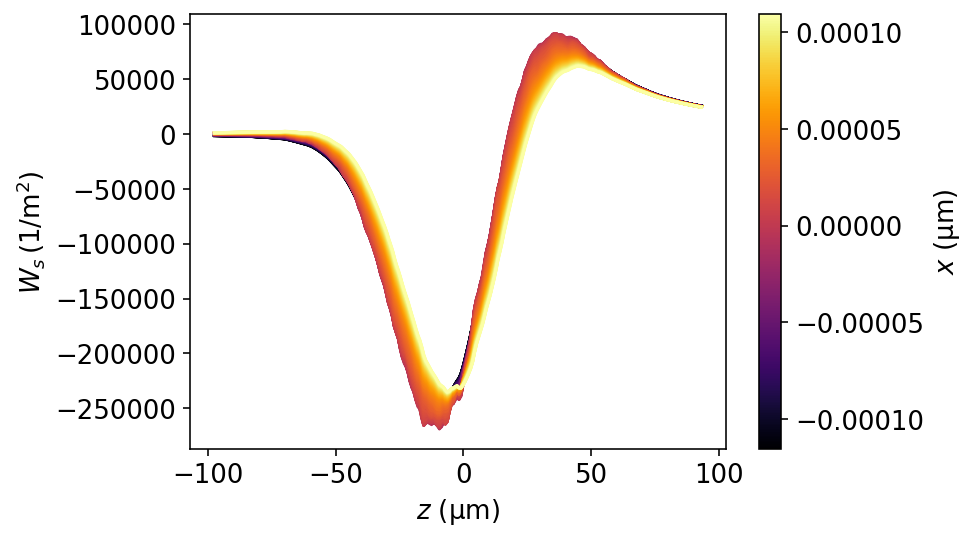

In [51]:
W=Ws_grid.T   # *kick_factor*p0c/W0

cmap = matplotlib.cm.get_cmap('inferno')
colors = cmap(np.linspace(0,1,len(W)))
fig, ax = plt.subplots(figsize=(6,4))
for i, ws in enumerate(W):
    ax.plot(zvec*1e6, ws, color=colors[i])
    
xmin = min(xvec) 
xmax = max(xvec)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=xmin, vmax=xmax))
cbar = fig.colorbar(sm)  

cbar.set_label('$x$'+' (µm)')
#ax.set_title('2D CSR wake')
ax.set_xlabel('$z$'+' (µm)')
ax.set_ylabel(r'$W_s\, (1/\mathrm{m^2})$')
plt.savefig('Ws.png', dpi=150)

# Dealing with boundary condition...

In [8]:
# Overtaking phi
print('Phi of the overtaking distance:', L0/10.34)

Phi of the overtaking distance: 0.03593962706139082


In [5]:
from csr2d.core2 import Es_case_B, Es_case_A, Fx_case_A

In [ ]:
lambda_grid_filtered, Es_case_B_grid, Es_case_A_grid, Fx_case_A_grid, Ws_case_B_grid, Ws_case_A_grid, Wx_case_A_grid

In [6]:
# phi is the angle into the bend 
# x_observe should be a value in x_vec ( zero might not be one )..... TO BE FIXED

def compute_transient_wake_case_B(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s, psi_x, ploton=True):

    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec2)

    
    # Want "True" if (z > zi) OR (z < zo), where the grid values are set to ZERO
    condition_grid = np.array([(zvec2 > zi_vec[i]) | (zvec2 < zo_vec[i]) for i in range(len(xvec2))])
    psi_s_grid_bounded = np.where(condition_grid.T, 0, psi_s_grid)
    
    # This section is just for illustration, not required
    if ploton:
        zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")
        zm2_bounded = zm2
        zm2_bounded[condition_grid.T] = 0
        plt.imshow(zm2_bounded.T, origin='lower')
        plt.colorbar()
        plt.xlabel('zvec2 index', fontsize=16)
        plt.ylabel('xvec2 index', fontsize=16)
        plt.title('z value with boundaries of $\psi_s$\n (x ='+ str(x_observe*1000)+'mm, $\phi=$'+str(phi)+')',  fontsize=20)
        #plt.clf()

    
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid_bounded, psi_x)
    Ws_grid = (beta**2 / abs(rho)) * (conv_s) * (dz * dx)
    
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    print('x_observe_index :', x_observe_index )
    
    #plt.scatter(zvec, Ws_grid[:,x_observe_index])
    
    #return Ws_grid[:,x_observe_index], condition_grid, psi_s_grid_bounded
    return Ws_grid[:,x_observe_index]
    #return Ws_grid

In [69]:
# phi is the angle into the bend 
# x_observe should be a value in x_vec ( zero might not be one )..... TO BE FIXED

def compute_transient_wake_case_A(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered, Es_grid, Fx_grid, ploton=True):

    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec2)

    
    # Want "True" if (z > zi), where the grid values are set to ZERO
    condition_grid = np.array([(zvec2 > zi_vec[i]) for i in range(len(xvec2))])
    Es_grid_bounded = np.where(condition_grid.T, 0, Es_grid)
    Fx_grid_bounded = np.where(condition_grid.T, 0, Fx_grid)
    
    # This section is just for illustration, not required
    if ploton:
        zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")
        zm2_bounded = zm2
        zm2_bounded[condition_grid.T] = 0
        plt.imshow(zm2_bounded.T, origin='lower')
        plt.colorbar()
        plt.xlabel('zvec2 index', fontsize=16)
        plt.ylabel('xvec2 index', fontsize=16)
        plt.title('z value with boundaries of $\psi_s$\n (x ='+ str(x_observe*1000)+'mm, $\phi=$'+str(phi)+')',  fontsize=20)
        #plt.clf()
    
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered, Es_grid_bounded, Fx_grid_bounded )
  
    Ws_grid = (1/gamma**2 / rho**2 ) * (conv_s) * (dz * dx)
    Wx_grid = (1/gamma**2 / rho**2 ) * (conv_x) * (dz * dx)
    
    
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    print('x_observe_index :', x_observe_index)
    
    #plt.scatter(zvec, Ws_grid[:,x_observe_index])
    
    #return Ws_grid[:,x_observe_index], condition_grid, psi_s_grid_bounded
    return Ws_grid[:,x_observe_index]
    #return Ws_grid

In [38]:
0.1/1.5

0.06666666666666667

x_observe_index : 299


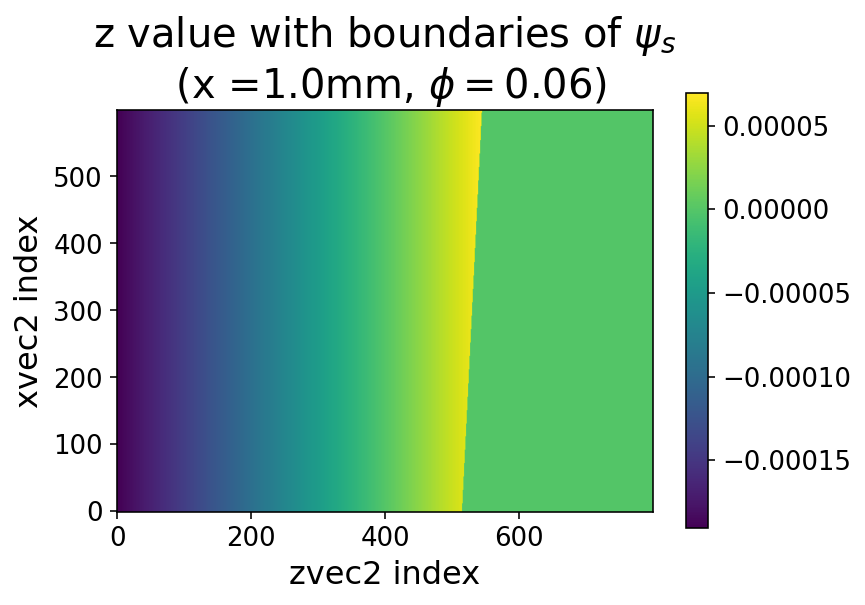

In [70]:
phi = 0.06
x_observe = 0.001
Ws_on_axis = compute_transient_wake_case_A(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered, Es_case_A_grid, Fx_case_A_grid)

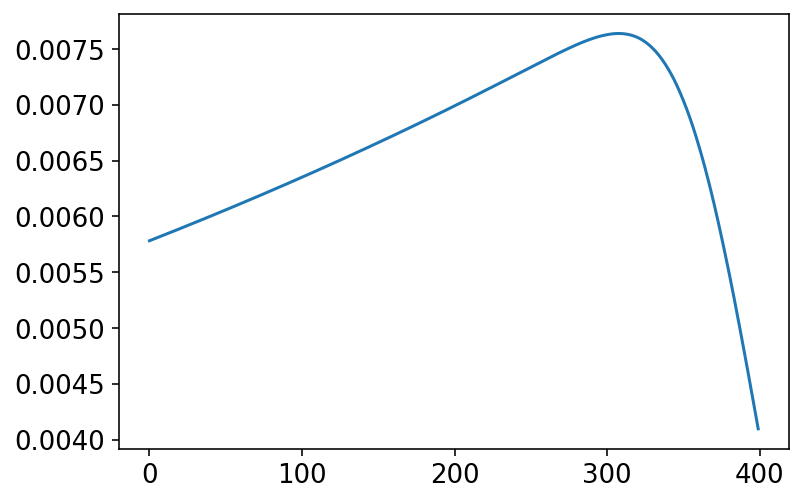

In [57]:
plt.plot(Ws_on_axis)

x_observe_index : 153


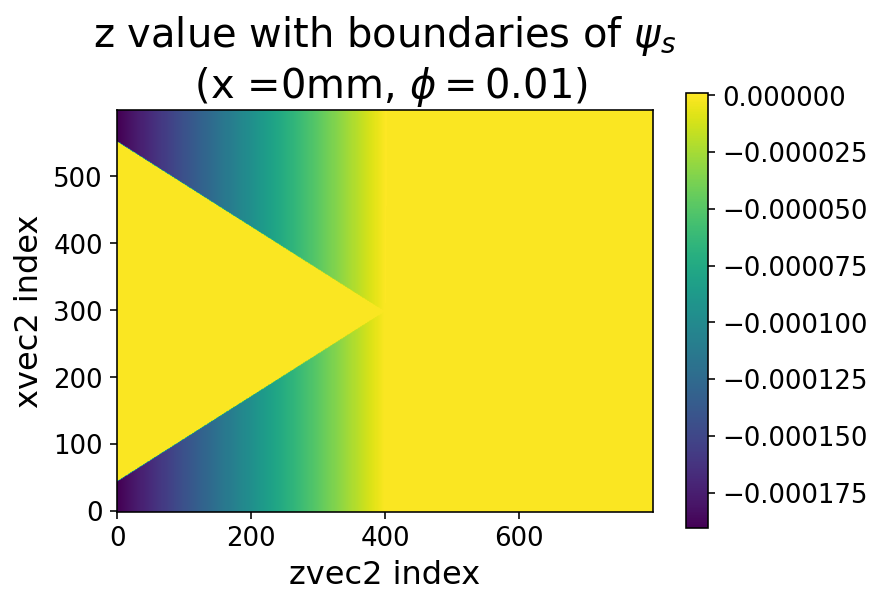

In [16]:
phi = 0.0001
phi = 0.01
x_observe = 0
Ws_on_axis = compute_transient_wake_case_B(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

x_observe_index : 102


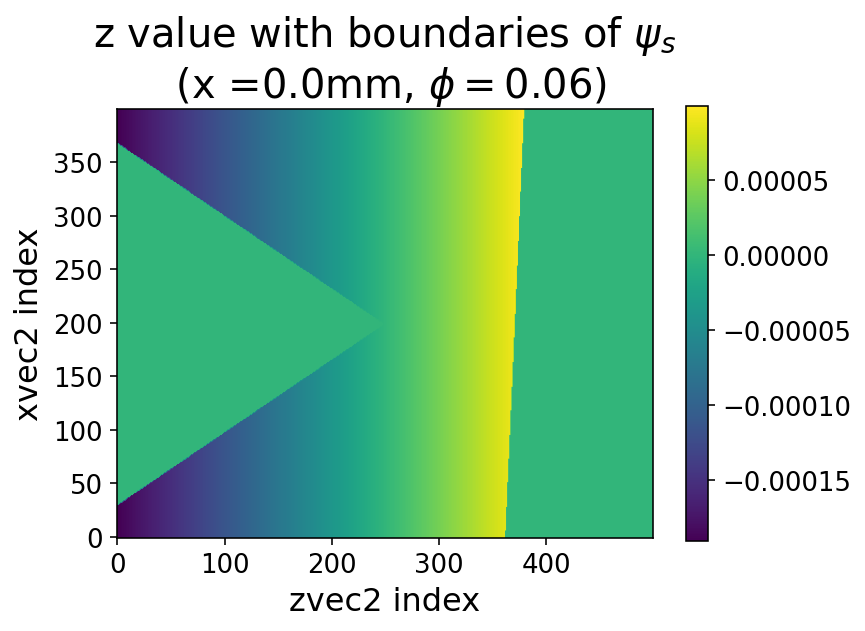

In [14]:
phi = 0.06
x_observe = 0.000
Ws_on_axis = compute_transient_wake_case_B(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

Text(0.5, 1.0, 'CSR wake along x=0\n $\\phi = $0.01')

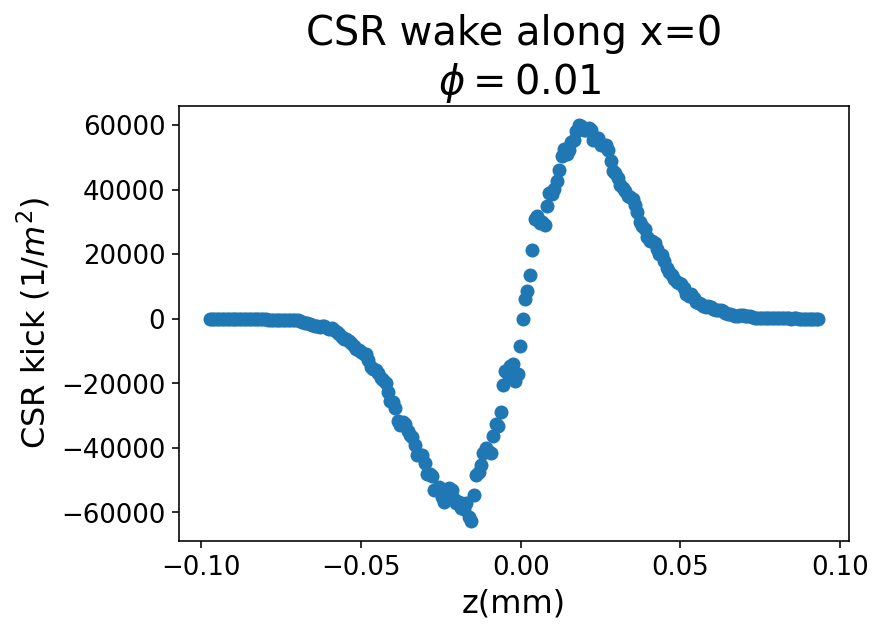

In [20]:
plt.clf()
#plt.scatter(zvec, Ws_on_axis)
plt.scatter(zvec*10**3, Ws_on_axis)

#kick_factor = r_e*Q/e_charge/gamma

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('CSR wake along x='+str(x_observe)+'\n $\phi = $'+str(phi),  fontsize=20)

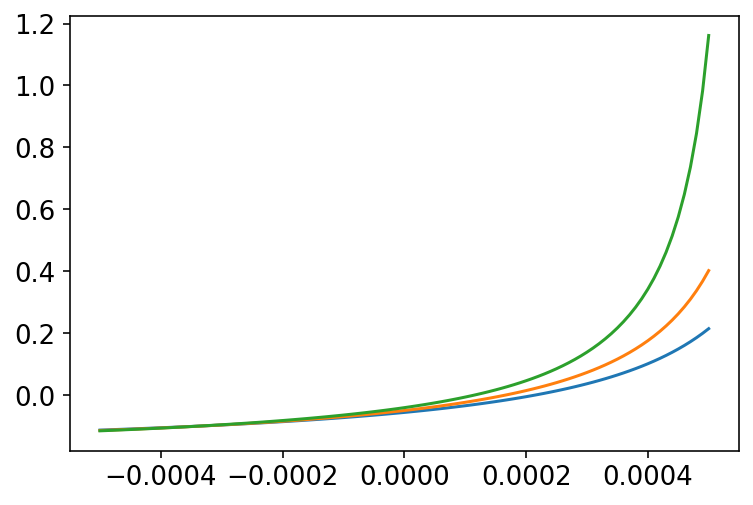

In [47]:
from csr2d.core2 import eta_case_A

gg = 5000
bb = (1-1/gg**2)**(1/2)

eta_lamb1 = lambda z : eta_case_A(z, -0.001, bb**2, 0.1)
eta_lamb2 = lambda z : eta_case_A(z, 0.000, bb**2, 0.1)
eta_lamb3 = lambda z : eta_case_A(z, 0.001, bb**2, 0.1)
zzz = np.linspace(-5e-4,5e-4,101)
eta_vec1 = list(map(eta_lamb1,zzz))
eta_vec2 = list(map(eta_lamb2,zzz))
eta_vec3 = list(map(eta_lamb3,zzz))

plt.plot(zzz, eta_vec1)
plt.plot(zzz, eta_vec2)
plt.plot(zzz, eta_vec3)

In [11]:
x_observe = 0.0

phi_vec = [0.008, 0.01, 0.02, 0.03, 0.05, 0.06, 0.1]
#phi_vec = [0.0666667]

ffA = lambda a : csr2d_kick_calc_case_A(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = a, x_observe = 0,
    nz=600, nx=500, debug=True)
wake_listA = np.array(list(map(ffA, phi_vec)))

Depositing particles takes: 0.015999555587768555 s
Computing potential grids take: 0.2014009952545166 s
Depositing particles takes: 0.015362262725830078 s
Computing potential grids take: 0.14938068389892578 s
Depositing particles takes: 0.013718605041503906 s
Computing potential grids take: 0.1508629322052002 s
Depositing particles takes: 0.0137176513671875 s
Computing potential grids take: 0.15006709098815918 s
Depositing particles takes: 0.014470338821411133 s
Computing potential grids take: 0.14945745468139648 s
Depositing particles takes: 0.01374959945678711 s
Computing potential grids take: 0.15015530586242676 s
Depositing particles takes: 0.014383554458618164 s
Computing potential grids take: 0.18626904487609863 s


In [213]:
wake_listA[0][2];

In [8]:
zvec = wake_listA[0][0]
zvec.size

600

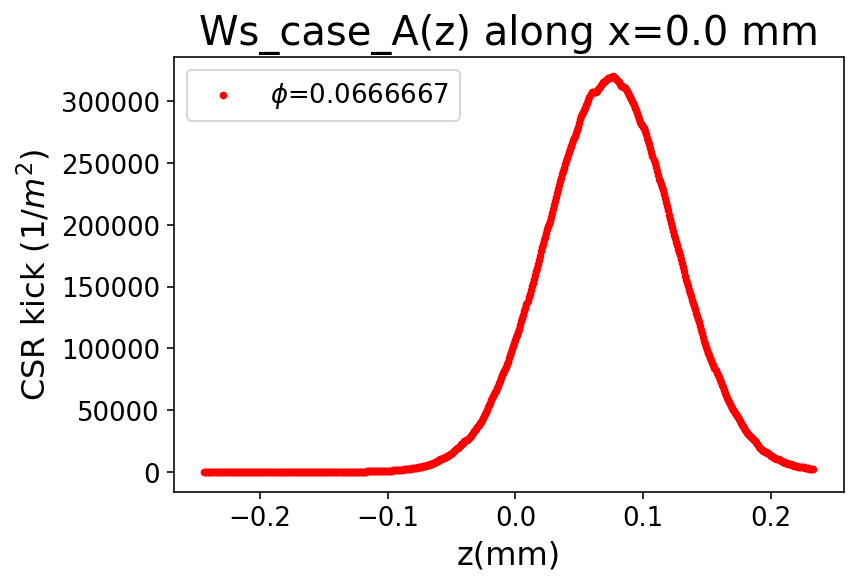

In [9]:
plt.scatter(zvec*10**3,wake_listA[0][2], color='red', label='$\phi$='+str(phi_vec[0]), s=8 )
plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws_case_A(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
plt.legend()

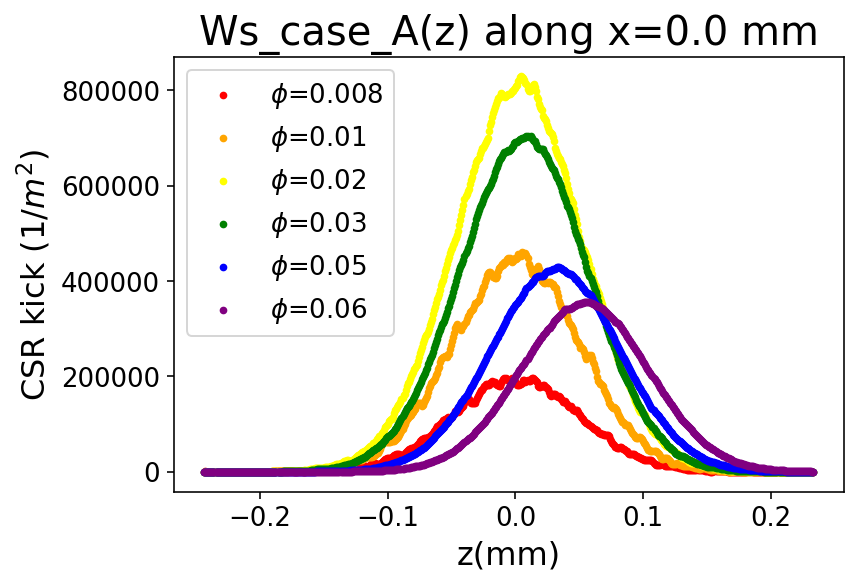

In [12]:
plt.scatter(zvec*10**3,wake_listA[0][2], color='red', label='$\phi$='+str(phi_vec[0]), s=8 )
plt.scatter(zvec*10**3,wake_listA[1][2], color='orange', label='$\phi$='+str(phi_vec[1]), s=8    )
plt.scatter(zvec*10**3,wake_listA[2][2], color='yellow', label='$\phi$='+str(phi_vec[2]), s=8    )
plt.scatter(zvec*10**3,wake_listA[3][2], color='green', label='$\phi$='+str(phi_vec[3]), s=8    )
plt.scatter(zvec*10**3,wake_listA[4][2], color='blue', label='$\phi$='+str(phi_vec[4]), s=8    )
plt.scatter(zvec*10**3,wake_listA[5][2], color='purple', label='$\phi$='+str(phi_vec[5]), s=8    )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws_case_A(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
plt.legend()

In [12]:
x_observe = 0.0

ffB = lambda a : compute_transient_wake_case_B(a, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, ploton=False)
phi_vec = [0.01, 0.02, 0.03, 0.05, 0.06, 0.07]
wake_list = list(map(ffB, phi_vec))

x_observe_index : 154
x_observe_index : 154
x_observe_index : 154
x_observe_index : 154
x_observe_index : 154
x_observe_index : 154


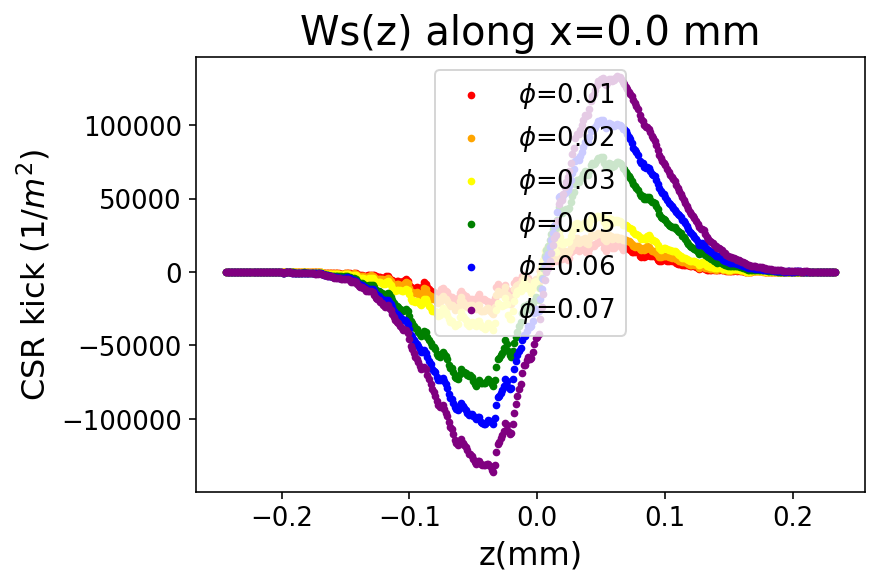

In [13]:
plt.scatter(zvec*10**3,wake_list[0], color='red', label='$\phi$=0.01', s=8 )
plt.scatter(zvec*10**3,wake_list[1], color='orange', label='$\phi$=0.02', s=8    )
plt.scatter(zvec*10**3,wake_list[2], color='yellow', label='$\phi$=0.03', s=8    )
plt.scatter(zvec*10**3,wake_list[3], color='green', label='$\phi$=0.05', s=8    )
plt.scatter(zvec*10**3,wake_list[4], color='blue', label='$\phi$=0.06', s=8    )
plt.scatter(zvec*10**3,wake_list[5], color='purple', label='$\phi$=0.07', s=8    )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
plt.legend()

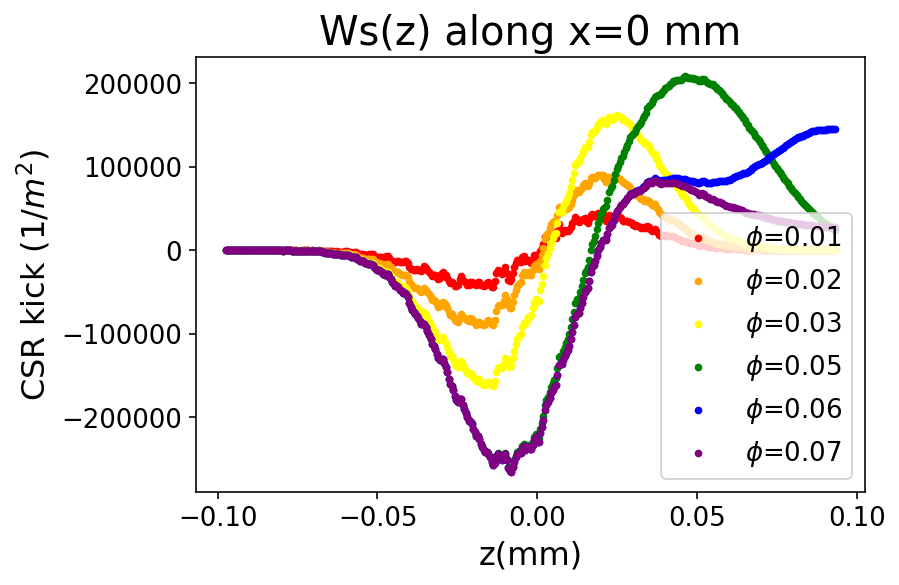

In [35]:
plt.scatter(zvec*10**3,wake_list[0], color='red', label='$\phi$=0.01', s=8 )
plt.scatter(zvec*10**3,wake_list[1], color='orange', label='$\phi$=0.02', s=8    )
plt.scatter(zvec*10**3,wake_list[2], color='yellow', label='$\phi$=0.03', s=8    )
plt.scatter(zvec*10**3,wake_list[3], color='green', label='$\phi$=0.05', s=8    )
plt.scatter(zvec*10**3,wake_list[4], color='blue', label='$\phi$=0.06', s=8    )
plt.scatter(zvec*10**3,wake_list[5], color='purple', label='$\phi$=0.07', s=8    )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
plt.legend()

## Tao

In [25]:
np.array(phi_vec)*rho

array([0.1034, 0.2068, 0.3102, 0.517 , 0.6204, 0.7238])

In [27]:
#from pytao.misc.csr import read_csr_wake_data_h5, process_csr_wake_data
from pytao.misc.csr import parse_csr_wake

# Below are scratch

In [96]:
print(zvec2[0])
print(zvec2[-1])
print(xvec2[0])
print(xvec2[-1])

-0.0001905963172391465
0.00020421033989908555
-0.0002247420826042827
0.0002497134251158697


In [100]:
zm2[:,0]

array([-1.90596317e-04, -1.76982295e-04, -1.63368272e-04, -1.49754249e-04,
       -1.36140227e-04, -1.22526204e-04, -1.08912181e-04, -9.52981586e-05,
       -8.16841360e-05, -6.80701133e-05, -5.44560906e-05, -4.08420680e-05,
       -2.72280453e-05, -1.36140227e-05,  0.00000000e+00,  1.36140227e-05,
        2.72280453e-05,  4.08420680e-05,  5.44560906e-05,  6.80701133e-05,
        8.16841360e-05,  9.52981586e-05,  1.08912181e-04,  1.22526204e-04,
        1.36140227e-04,  1.49754249e-04,  1.63368272e-04,  1.76982295e-04,
        1.90596317e-04,  2.04210340e-04])

In [109]:
zm2[:,1]

array([-1.90596317e-04, -1.76982295e-04, -1.63368272e-04, -1.49754249e-04,
       -1.36140227e-04, -1.22526204e-04, -1.08912181e-04, -9.52981586e-05,
       -8.16841360e-05, -6.80701133e-05, -5.44560906e-05, -4.08420680e-05,
       -2.72280453e-05, -1.36140227e-05,  0.00000000e+00,  1.36140227e-05,
        2.72280453e-05,  4.08420680e-05,  5.44560906e-05,  6.80701133e-05,
        8.16841360e-05,  9.52981586e-05,  1.08912181e-04,  1.22526204e-04,
        1.36140227e-04,  1.49754249e-04,  1.63368272e-04,  1.76982295e-04,
        1.90596317e-04,  2.04210340e-04])

In [115]:
zvec2

array([-1.90596317e-04, -1.76982295e-04, -1.63368272e-04, -1.49754249e-04,
       -1.36140227e-04, -1.22526204e-04, -1.08912181e-04, -9.52981586e-05,
       -8.16841360e-05, -6.80701133e-05, -5.44560906e-05, -4.08420680e-05,
       -2.72280453e-05, -1.36140227e-05,  0.00000000e+00,  1.36140227e-05,
        2.72280453e-05,  4.08420680e-05,  5.44560906e-05,  6.80701133e-05,
        8.16841360e-05,  9.52981586e-05,  1.08912181e-04,  1.22526204e-04,
        1.36140227e-04,  1.49754249e-04,  1.63368272e-04,  1.76982295e-04,
        1.90596317e-04,  2.04210340e-04])

In [217]:
zvec2 > zi_vec[10]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [218]:
zvec2 < zo_vec[10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [219]:
(zvec2 > zi_vec[10]) | (zvec2 < zo_vec[10])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [343]:
# Want "True" if (z > zi) OR (z < zo)

condition_grid = np.array([(zvec2 > zi_vec[i]) | (zvec2 < zo_vec[i]) for i in range(len(xvec2))])

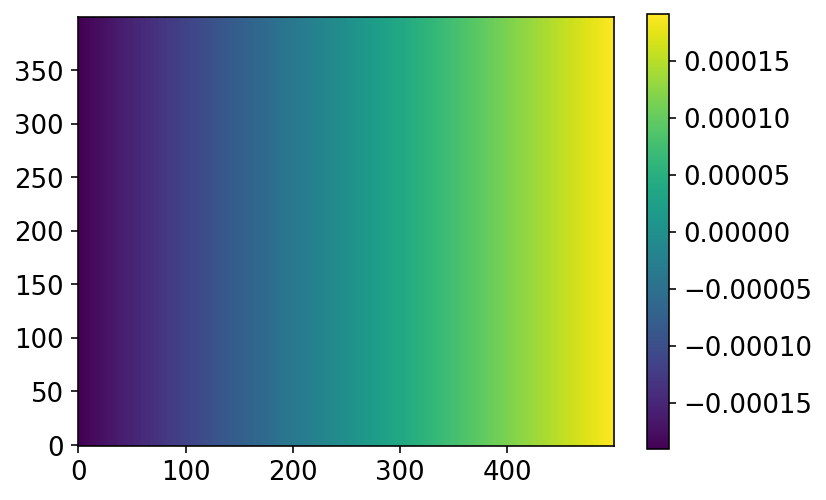

In [544]:
plt.imshow(zm2.T, origin='lower')
plt.colorbar()

In [211]:
zi_vec[10]

0.09264953752397259

In [344]:
zm2_bounded = zm2.copy()
zm2_bounded[condition_grid.T]=0

psi_s_grid_bounded = psi_s_grid.copy()
psi_s_grid_bounded[condition_grid.T]=0

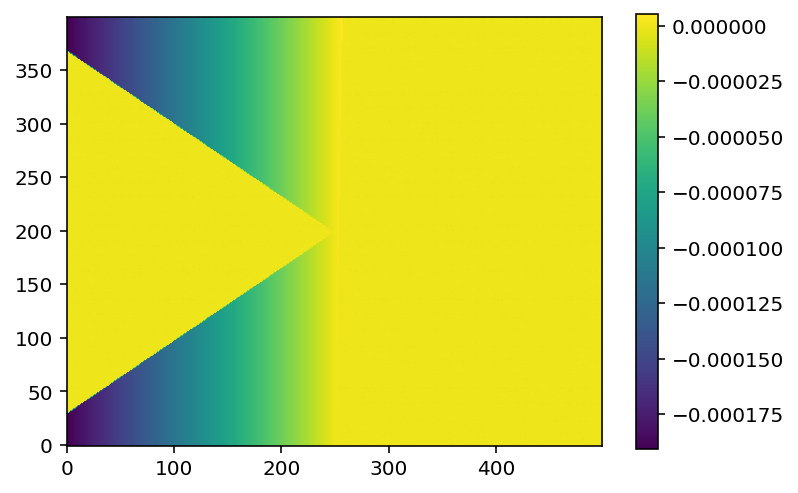

In [345]:
plt.imshow(zm2_bounded.T, origin='lower')
plt.colorbar()

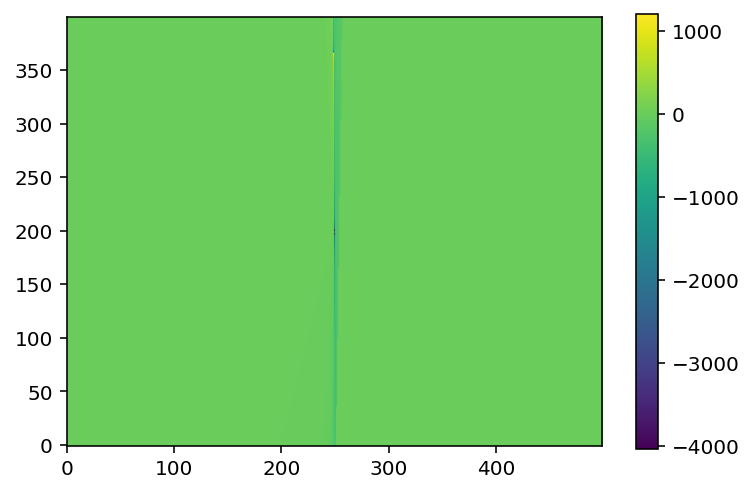

In [346]:
plt.imshow(psi_s_grid_bounded.T, origin='lower')
plt.colorbar()

In [347]:
conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid_bounded, psi_x_grid)
Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)

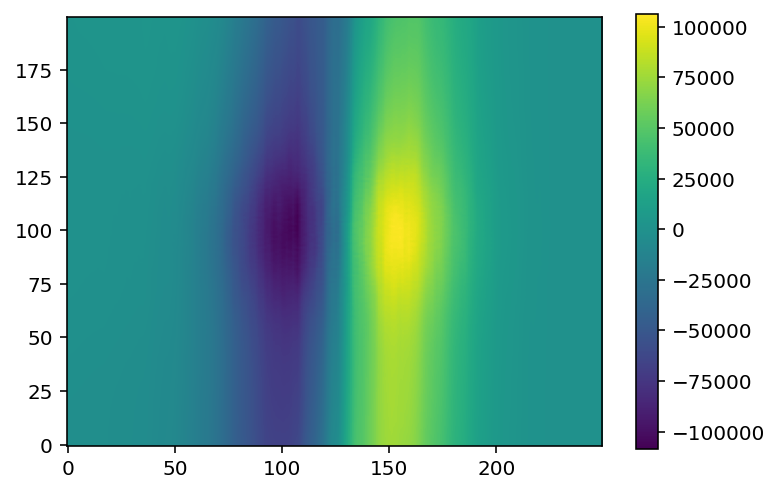

In [348]:
plt.imshow(Ws_grid.T, origin='lower')
plt.colorbar()

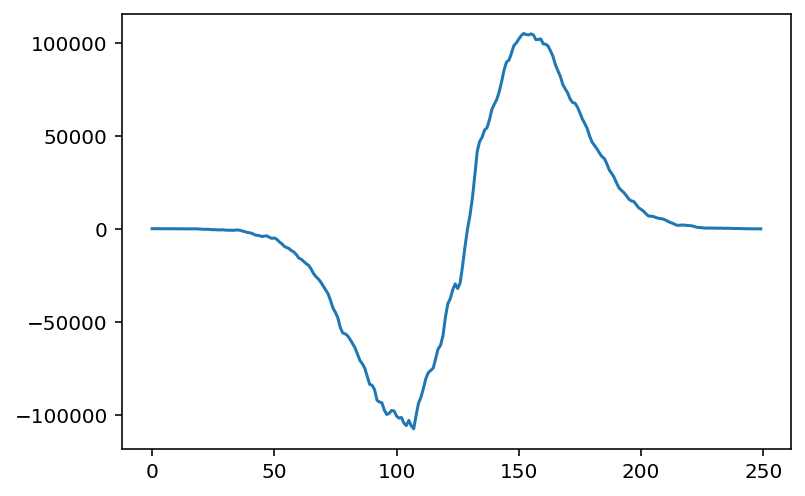

In [349]:
plt.plot(Ws_grid[:,100])

In [262]:
from scipy.signal import fftconvolve

in1 = [[3,4,5],[1,2,3],[7,8,9]]
in1 = [[1,1,1],[1,2,1],[1,1,1]]
in2 = [[1,1,1],[1,1,1],[1,1,1]]
fftconvolve(in1, in2, mode='same', axes=None)

array([[ 5.,  7.,  5.],
       [ 7., 10.,  7.],
       [ 5.,  7.,  5.]])